In [1]:
import tensorflow as tf #need to conda install keras for tf version 2.6+
print(tf.__version__)
import tensorflow_hub as hub

import requests
import numpy as np

from typing import Generator, Iterable, List, Optional
import mediapy as media
import os

2.6.0


In [2]:
model = hub.load("https://tfhub.dev/google/film/1")

In [3]:
_UINT8_MAX_F = float(np.iinfo(np.uint8).max)

def load_image(img_url: str):
  """Returns an image with shape [height, width, num_channels], with pixels in [0..1] range, and type np.float32."""

  if (img_url.startswith("https")):
    user_agent = {'User-agent': 'Colab Sample (https://tensorflow.org)'}
    response = requests.get(img_url, headers=user_agent)
    image_data = response.content
  else:
    image_data = tf.io.read_file(img_url)

  image = tf.io.decode_image(image_data, channels=3)
  image_numpy = tf.cast(image, dtype=tf.float32).numpy()
  return image_numpy / _UINT8_MAX_F

In [ ]:
def write_image(filename: str, image: np.ndarray) -> None:
  """Writes a float32 3-channel RGB ndarray image, with colors in range [0..1].
  Args:
    filename: The output filename to save.
    image: A float32 3-channel (RGB) ndarray with colors in the [0..1] range.
  """
  image_in_uint8_range = np.clip(image * _UINT8_MAX_F, 0.0, _UINT8_MAX_F)
  image_in_uint8 = (image_in_uint8_range + 0.5).astype(np.uint8)

  extension = os.path.splitext(filename)[1]
  if extension == '.jpg':
    image_data = tf.io.encode_jpeg(image_in_uint8)
  else:
    image_data = tf.io.encode_png(image_in_uint8)
  tf.io.write_file(filename, image_data)

In [ ]:
def _output_frames(frames: List[np.ndarray], frames_dir: str):
  """Writes PNG-images to a directory.
  If frames_dir doesn't exist, it is created. If frames_dir contains existing
  PNG-files, they are removed before saving the new ones.
  Args:
    frames: List of images to save.
    frames_dir: The output directory to save the images.
  """
  if tf.io.gfile.isdir(frames_dir):
    old_frames = tf.io.gfile.glob(f'{frames_dir}/frame_*.png')
    if old_frames:
      logging.info('Removing existing frames from %s.', frames_dir)
      for old_frame in old_frames:
        tf.io.gfile.remove(old_frame)
  else:
    tf.io.gfile.makedirs(frames_dir)
  for idx, frame in tqdm(
      enumerate(frames), total=len(frames), ncols=100, colour='green'):
    util.write_image(f'{frames_dir}/frame_{idx:03d}.png', frame)
  logging.info('Output frames saved in %s.', frames_dir)

In [4]:
# using images from the FILM repository (https://github.com/google-research/frame-interpolation/)

image_1_url = "https://github.com/google-research/frame-interpolation/blob/main/photos/one.png?raw=true"
image_2_url = "https://github.com/google-research/frame-interpolation/blob/main/photos/two.png?raw=true"

time = np.array([0.5], dtype=np.float32)

image1 = load_image(image_1_url)
image2 = load_image(image_2_url)

In [5]:
input = {
    'time': np.expand_dims(time, axis=0), # adding the batch dimension to the time
     'x0': np.expand_dims(image1, axis=0), # adding the batch dimension to the image
     'x1': np.expand_dims(image2, axis=0)  # adding the batch dimension to the image
}
mid_frame = model(input)
write_image('temp.png',mid_frame)

input image one,generated image,input image two

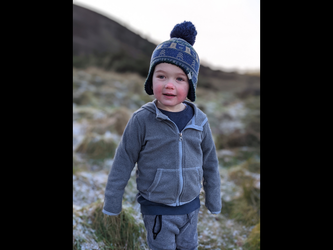
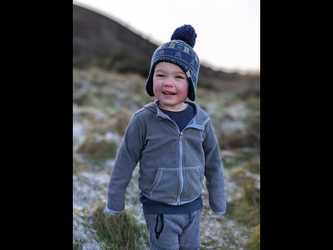
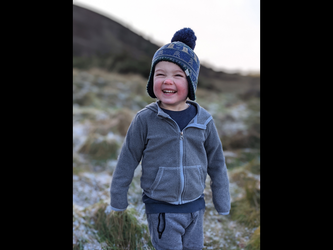

In [6]:
frames = [image1, mid_frame['image'][0].numpy(), image2]

media.show_images(frames, titles=['input image one', 'generated image', 'input image two'], height=250)

In [7]:
media.show_video(frames, fps=3, title='FILM interpolated video')

In [8]:
"""A wrapper class for running a frame interpolation based on the FILM model on TFHub

Usage:
  interpolator = Interpolator()
  result_batch = interpolator(image_batch_0, image_batch_1, batch_dt)
  Where image_batch_1 and image_batch_2 are numpy tensors with TF standard
  (B,H,W,C) layout, batch_dt is the sub-frame time in range [0..1], (B,) layout.
"""


def _pad_to_align(x, align):
  """Pads image batch x so width and height divide by align.

  Args:
    x: Image batch to align.
    align: Number to align to.

  Returns:
    1) An image padded so width % align == 0 and height % align == 0.
    2) A bounding box that can be fed readily to tf.image.crop_to_bounding_box
      to undo the padding.
  """
  # Input checking.
  assert np.ndim(x) == 4
  assert align > 0, 'align must be a positive number.'

  height, width = x.shape[-3:-1]
  height_to_pad = (align - height % align) if height % align != 0 else 0
  width_to_pad = (align - width % align) if width % align != 0 else 0

  bbox_to_pad = {
      'offset_height': height_to_pad // 2,
      'offset_width': width_to_pad // 2,
      'target_height': height + height_to_pad,
      'target_width': width + width_to_pad
  }
  padded_x = tf.image.pad_to_bounding_box(x, **bbox_to_pad)
  bbox_to_crop = {
      'offset_height': height_to_pad // 2,
      'offset_width': width_to_pad // 2,
      'target_height': height,
      'target_width': width
  }
  return padded_x, bbox_to_crop


class Interpolator:
  """A class for generating interpolated frames between two input frames.

  Uses the Film model from TFHub
  """

  def __init__(self, align: int = 64) -> None:
    """Loads a saved model.

    Args:
      align: 'If >1, pad the input size so it divides with this before
        inference.'
    """
    self._model = hub.load("https://tfhub.dev/google/film/1")
    self._align = align

  def __call__(self, x0: np.ndarray, x1: np.ndarray,
               dt: np.ndarray) -> np.ndarray:
    """Generates an interpolated frame between given two batches of frames.

    All inputs should be np.float32 datatype.

    Args:
      x0: First image batch. Dimensions: (batch_size, height, width, channels)
      x1: Second image batch. Dimensions: (batch_size, height, width, channels)
      dt: Sub-frame time. Range [0,1]. Dimensions: (batch_size,)

    Returns:
      The result with dimensions (batch_size, height, width, channels).
    """
    if self._align is not None:
      x0, bbox_to_crop = _pad_to_align(x0, self._align)
      x1, _ = _pad_to_align(x1, self._align)

    inputs = {'x0': x0, 'x1': x1, 'time': dt[..., np.newaxis]}
    result = self._model(inputs, training=False)
    image = result['image']

    if self._align is not None:
      image = tf.image.crop_to_bounding_box(image, **bbox_to_crop)
    return image.numpy()

In [9]:
def _recursive_generator(
    frame1: np.ndarray, frame2: np.ndarray, num_recursions: int,
    interpolator: Interpolator) -> Generator[np.ndarray, None, None]:
  """Splits halfway to repeatedly generate more frames.

  Args:
    frame1: Input image 1.
    frame2: Input image 2.
    num_recursions: How many times to interpolate the consecutive image pairs.
    interpolator: The frame interpolator instance.

  Yields:
    The interpolated frames, including the first frame (frame1), but excluding
    the final frame2.
  """
  if num_recursions == 0:
    yield frame1
  else:
    # Adds the batch dimension to all inputs before calling the interpolator,
    # and remove it afterwards.
    time = np.full(shape=(1,), fill_value=0.5, dtype=np.float32)
    mid_frame = interpolator(
        np.expand_dims(frame1, axis=0), np.expand_dims(frame2, axis=0), time)[0]
    yield from _recursive_generator(frame1, mid_frame, num_recursions - 1,
                                    interpolator)
    yield from _recursive_generator(mid_frame, frame2, num_recursions - 1,
                                    interpolator)


def interpolate_recursively(
    frames: List[np.ndarray], num_recursions: int,
    interpolator: Interpolator) -> Iterable[np.ndarray]:
  """Generates interpolated frames by repeatedly interpolating the midpoint.

  Args:
    frames: List of input frames. Expected shape (H, W, 3). The colors should be
      in the range[0, 1] and in gamma space.
    num_recursions: Number of times to do recursive midpoint
      interpolation.
    interpolator: The frame interpolation model to use.

  Yields:
    The interpolated frames (including the inputs).
  """
  n = len(frames)
  for i in range(1, n):
    yield from _recursive_generator(frames[i - 1], frames[i],
                                    times_to_interpolate, interpolator)
  # Separately yield the final frame.
  yield frames[-1]

In [10]:
times_to_interpolate = 6
interpolator = Interpolator()

In [11]:
input_frames = [image1, image2]
frames = list(
    interpolate_recursively(input_frames, times_to_interpolate,
                                        interpolator))

In [12]:
print(f'video with {len(frames)} frames')
media.show_video(frames, fps=30, title='FILM interpolated video')

video with 65 frames


In [29]:
import cv2

# specify video
height, width, layers = image1.shape
video_name = 'tmp.avi'
fps=20
fourcc=cv2.VideoWriter_fourcc(*'MJPG')
# fourcc=cv2.VideoWriter_fourcc(*'h264')
# fourcc=cv2.VideoWriter_fourcc(*'DIVX')
iscolor=True
video = cv2.VideoWriter(video_name, fourcc, fps, (width,height),iscolor)

# Appending the images to the video one by one
for frame in frames:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    video.write(frame)

# Deallocating memories taken for window creation
cv2.destroyAllWindows()
video.release()  # releasing the video generated

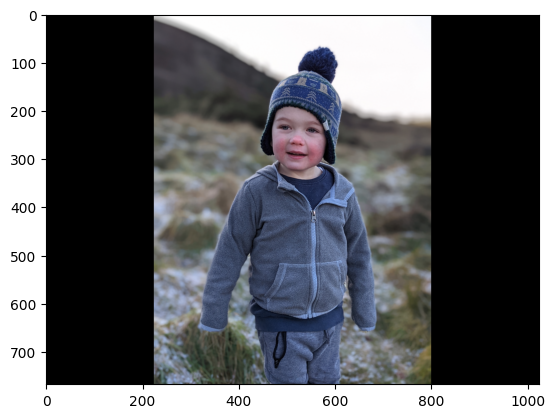

In [26]:
from matplotlib import pyplot as plt
plt.imshow(frames[12])

In [27]:
np.min(frame),np.max(frame)

(0.0, 1.0)